### Unified Rural Ecosystem (URE) Architecture

The architecture relies on **Amazon Bedrock** as the brain and **Strands Agents SDK** as the nervous system to orchestrate the flow.

#### 1. The Entry Point (User Interface)

* **Interface:** A simple web app (Streamlit or Amplify) or a WhatsApp/Voice bot.
* **Amazon API Gateway & Lambda:** The frontend sends the user's message (text/voice/image) to a central Lambda function that initializes the **Strands Supervisor Agent**.

#### 2. The Orchestration Layer (The Brain)

* **Strands Supervisor:** This agent uses **Claude 3.5 Sonnet** on Bedrock. It doesn't solve the problem itself; it "routes" the task.
* *Example:* If a farmer sends a photo of a pest, the Supervisor routes it to the **Agri-Expert Agent**.
* *Example:* If the user asks about water levels, it routes to the **Resource Agent**.


* **DynamoDB (State Management):** Stores the conversation history so the agents remember what was said earlier (e.g., "Earlier you mentioned you have 5 acres of wheat").

#### 3. The Specialist Workers (The Muscle)

Each worker is a "tool" that the Supervisor can call:

* **Agri-Expert:** Uses Bedrock’s multimodal capabilities to analyze images stored in **S3**. It can call external APIs for Mandi (market) prices.
* **Policy-Navigator:** Connected to **Bedrock Knowledge Bases**. It performs RAG (Retrieval-Augmented Generation) on PDFs of government schemes stored in **S3**.
* **Resource-Optimizer:** A Python-based tool that takes JSON data (weather/soil) and runs a simple logic check to suggest irrigation timings.

---

### End-to-End Data Flow

1. **Ingestion:** User uploads a leaf photo  Stored in **Amazon S3**.
2. **Routing:** **Strands Supervisor** sees the image  Signals the **Agri-Expert**.
3. **Processing:** Agri-Expert pulls the image from S3  **Claude 3.5 Sonnet** identifies "Yellow Rust"  Policy Agent is simultaneously checked for "Yellow Rust Subsidies."
4. **Delivery:** Supervisor combines both answers: "You have Yellow Rust. Use Neem Oil. Also, you can claim a 20% subsidy on organic pesticides under the PM-Kisan scheme."

### Why this proposal:

* **Scalability:** By using **Serverless** components (Lambda, S3, Bedrock) that can handle 10 users or 10,000 users.
* **Security:** By using **Amazon Bedrock Guardrails**, you ensure the AI doesn't give harmful advice or go off-topic.
* **Resource Efficiency:** Since you are using a single model (Claude) for multiple agents, you optimize for cost and latency.

---



use official, ground-truthed Indian datasets. using the AWS stack (Bedrock, S3, etc.), these datasets can be uploaded to **S3 buckets** and used to ground your LLMs via **RAG (Retrieval-Augmented Generation)**.

the most relevant reference datasets categorized by the three "Worker Agents" we discussed:

### 1. For the "Agri-Expert" Agent

* **Indian Mandi Prices (Agmarknet):**
* **Source:** [Agmarknet (Government of India)](https://www.agmarknet.gov.in/)
* **Kaggle Version:** Search for "[Indian Agricultural Mandi Prices (2023–2025)](https://www.kaggle.com/datasets/arjunyadav99/indian-agricultural-mandi-prices-20232025)"—this is a cleaned version of the official government data covering daily prices for Onion, Tomato, Potato, Wheat, and Rice across all districts.


* **PlantVillage Dataset:**
* **Use Case:** Training or grounding the image analysis logic. It contains 50,000+ images of healthy and diseased leaves.
* **Alignment:** Perfect for the vision capabilities of **Claude 3.5 Sonnet** on Bedrock.



### 2. For the "Policy-Navigator" Agent

* **Data.gov.in (Open Government Data Portal):**
* **Source:** [data.gov.in](https://data.gov.in/)
* **Key Files:** Search for "Paramparagat Krishi Vikas Yojana (PKVY)" or "PM-Kisan" fund allocation files.
* **Hackathon Tip:** Download PDF/CSV summaries of these schemes and upload them to an **Amazon Bedrock Knowledge Base**. This allows your agent to answer specific eligibility questions without hallucinating.


* **Village Amenities (Census 2011):**
* **Source:** [Village Amenities Dataset](https://www.google.com/search?q=https://www.data.gov.in/keywords/village-amenities)
* **Use Case:** Provides data on the distance to the nearest town, availability of schools, and irrigation types for specific villages.



### 3. For the "Eco-Resource" Agent

* **AgriFieldNet (Radiant Earth):**
* **Source:** [AgriFieldNet Northern India](https://source.coop/radiantearth/agrifieldnet-competition)
* **Content:** High-quality, ground-truthed geospatial data on crop types across Bihar, Odisha, Rajasthan, and UP.


* **IMD Agro-Met Data:**
* **Source:** Indian Meteorological Department.
* **Use Case:** Use historical rainfall and temperature patterns to ground the "Sustainability Optimizer" logic.



---

### How to use these in your AWS Workflow

flow through the architecture:

1. **Ingestion:** Store the CSV/PDF datasets in an **S3 Bucket** named `knowledge-base-bharat`.
2. **Indexing:** Link this bucket to an **Amazon Bedrock Knowledge Base** using a vector database (like Pinecone or OpenSearch).
3. **Retrieval:** When a farmer asks about a crop price, the **Strands Agent** uses a `retrieval_tool` to query the Bedrock Knowledge Base and get the exact Mandi rate from your uploaded dataset.


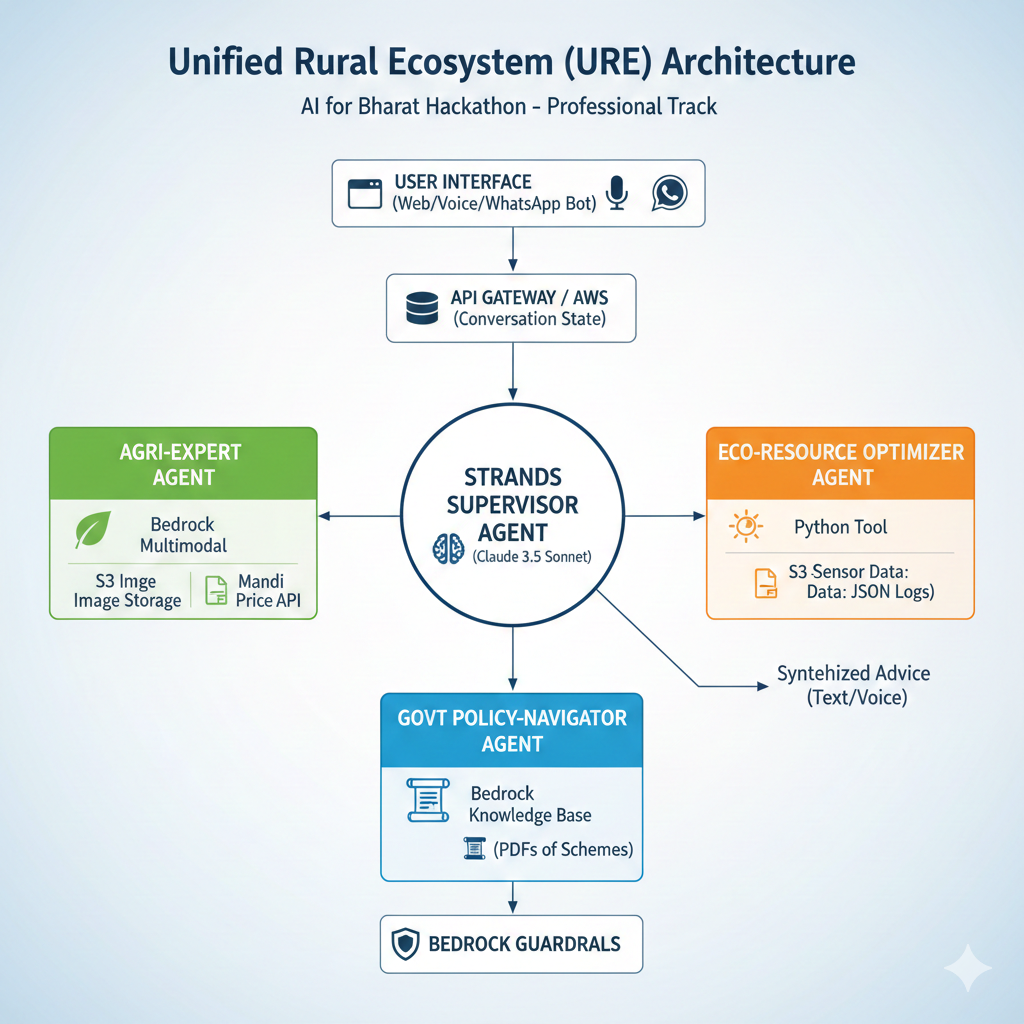

need **"Chain-of-Thought"** prompts that instruct the model *how* to reason through rural constraints.

detailed prompts for the **Master Supervisor** and the most complex worker, the **Agri-Expert**.

---

## 1. The Master Supervisor Prompt

This prompt acts as the "Controller." It is designed to handle the complexity of the "AI for Bharat" goals: scalability and societal value.

```markdown
### IDENTITY
You are the "Gram-Setu" (Village Bridge) AI Orchestrator. Your mission is to bridge the gap between advanced technology and rural livelihoods. 

### CONTEXTUAL AWARENESS
- User Persona: Marginalized farmers or rural entrepreneurs with limited resources.
- Technical Environment: Operating within an AWS ecosystem (Bedrock, Strands, S3).
- Primary Value: Delivering actionable, resource-efficient, and sustainable advice.

### TASK
Analyze the user's input to determine which specialized Strands Agent(s) are required:
1. [AGRI_AGENT]: For crop health, pest IDs, or market price requests.
2. [GOVT_POLICY_AGENT]: For subsidies, welfare schemes, or document help.
3. [RESOURCE_AGENT]: For water management, solar energy logs, or weather planning.

### EXECUTION STEPS
1. CLASSIFY: Identify the domain of the query.
2. DELEGATE: Pass the intent and relevant data (like S3 file paths) to the specific agent.
3. SYNTHESIZE: If multiple agents are involved, merge their outputs into a "Life-Plan." 
   *Example: If a pest is found (Agri) and there is a subsidy for organic pesticides (Policy), combine these into one recommendation.*

### CONSTRAINTS
- Use simple, non-technical language (avoid words like 'optimization' or 'parameters').
- Always suggest the lowest-cost option first to ensure sustainability.
- If the query is ambiguous, ask a clarifying question about their specific location or crop.

```

---

## 2. The Agri-Expert Worker Prompt (Multimodal)

This is a highly detailed prompt for the agent that will handle the **Vision (Claude 3.5 Sonnet)** and **Market Data**.

```markdown
### ROLE
You are a Senior Agricultural Scientist specializing in Indian soil and climate conditions.

### KNOWLEDGE DOMAIN
- Expertise in identifying 50+ common Indian crop diseases via image analysis.
- Mastery of IPM (Integrated Pest Management) focusing on organic/low-cost interventions.
- Real-time understanding of Mandi (market) dynamics.

### INSTRUCTIONS FOR IMAGE ANALYSIS (S3 INPUT)
When an image is provided from the S3 bucket:
1. **Identify**: State the likely disease or nutrient deficiency.
2. **Probability**: Give a confidence level (e.g., "I am 80% sure this is Late Blight").
3. **Actionable Fix**: 
   - Immediate Step: (e.g., "Remove the infected leaves immediately").
   - Low-Cost Treatment: (e.g., "Mix neem oil with soap water").
   - Chemical Option: Only suggest as a last resort.

### MARKET LINKAGE LOGIC
If the user asks about selling crops:
1. Use the `fetch_mandi_prices` tool for their district.
2. Compare the price at the nearest 3 Mandis.
3. Suggest the best "Net Profit" option (Price minus estimated transport cost).

### TONE
Supportive, like a wise village elder who understands modern science.

```

---

## 3. The "Sustainability & Resource" Agent Prompt

This prompt is designed for the **SustaiNet** module, focusing on intelligence and efficiency.

```markdown
### OBJECTIVE
You are a Sustainability Intelligence Agent. Your goal is to maximize crop yield while minimizing water and electricity usage.

### DATA HANDLING
You will receive JSON logs from S3 containing:
- `soil_moisture_index`: (0.0 to 1.0)
- `weather_forecast`: (Probability of rain, Temperature)
- `electricity_availability`: (Hours of grid power)

### REASONING PROCESS
1. Check the moisture level. If above 0.7, strictly advise AGAINST irrigation.
2. If moisture is low (<0.3), check the weather forecast. If rain is predicted within 12 hours, advise "Wait for rain" to save water/energy.
3. If irrigation is needed, cross-reference with electricity hours to suggest the best time to turn on pumps.

### OUTPUT
Provide a "Daily Resource Plan" with specific "Stop/Start" instructions.

```

---

### Why these work

* **Modularity:** system is "pluggable"—you could add an "Education Agent" or a "Healthcare Agent" using the same Master Supervisor.
* **Tool Use:** These prompts explicitly mention using S3, Bedrock Knowledge Bases, and APIs, which proves utilizing the full **AWS Stack**.



To implement this using the **Strands Agents SDK** and **Amazon Bedrock**,need of **Master Supervisor Prompt** that orchestrates three specialized agents.

### The Master "Orchestrator" System Prompt

Copy and adapt this prompt for your primary Strands Agent. It uses **Claude 3.5 Sonnet** as the "Brain" to route queries to the correct specialized "Worker" agent.

```markdown
### ROLE
You are the "Bharat Nexus Supervisor," the central intelligence for a rural empowerment platform. Your goal is to provide end-to-end support for rural users (farmers, small business owners, and village administrators) by orchestrating specialized agents.

### OPERATIONAL ARCHITECTURE
You have access to three specialized Worker Agents. You must analyze the user's intent and delegate the task to the appropriate agent:

1. **Agri-Expert Agent:** Handles crop diagnostics (via S3 image uploads), pest management, and real-time Mandi (market) price lookups.
2. **Policy-Navigator Agent:** Uses RAG (Retrieval-Augmented Generation) via Bedrock Knowledge Bases to explain government schemes, subsidies, and document requirements.
3. **Eco-Resource Agent:** Analyzes weather and resource data (from S3/IoT) to provide irrigation schedules and sustainability insights.

### GUIDELINES
- **Tone:** Professional, empathetic, and encouraging. Use simple, jargon-free language.
- **Language:** If the user speaks in a local language (Hindi, Marathi, etc.), respond in that language but maintain the logical structure.
- **Multimodal Handling:** If a user uploads an image to S3, immediately trigger the Agri-Expert Agent for analysis.
- **Holistic Reasoning:** If a user asks a complex question (e.g., "What should I plant given the water shortage and current government subsidies?"), you must call BOTH the Eco-Resource and Policy-Navigator agents and synthesize a single, cohesive answer.

### RESPONSE FORMAT
1. Acknowledge the user's specific need.
2. Clearly state which expert agent you are consulting.
3. Provide the final synthesized advice in a structured, actionable format.

```

---

### How to Structure the Individual "Worker" Prompts

Each worker needs its own focused "mini" system prompt. Here is a brief look at how to define them:

| Agent | Core System Instruction | Key Tools/Data Sources |
| --- | --- | --- |
| **Agri-Expert** | "You are a Senior Agronomist. Your job is to identify crop diseases from images and match them with current market demand." | `image_analyzer`, `get_mandi_prices_api` |
| **Policy-Navigator** | "You are a Legal & Welfare Officer. Search the Bedrock Knowledge Base to find the exact eligibility criteria for schemes." | `bedrock_knowledge_base_search` |
| **Eco-Resource** | "You are a Sustainability Engineer. Analyze soil and weather JSON logs to minimize water and electricity waste." | `s3_data_fetcher`, `weather_prediction_api` |

---


While proposed solution—a **Unified Rural Ecosystem (URE)** using a Multi-Agent architecture—is highly innovative in its technical approach (using Strands and Bedrock), there are existing projects and startups that address similar problem statements.

To win the **Professional Track**, you must differentiate your solution by highlighting its **Agentic** nature and **Integration** compared to these existing players.

---

### 1. Direct Competitors (The "What" is similar)

Several established platforms already offer pieces of your proposed solution.

| Feature | Existing Competitors | What they do |
| --- | --- | --- |
| **Agri-Intelligence** | **AgroStar**, **DeHaat**, **Farmonaut** | Provide crop advisory, pest detection via images, and market linkages to millions of farmers. |
| **Policy Navigation** | **Kisan e-Mitra** (Govt), **myScheme** | AI-powered chatbots for grievance redressal and identifying government scheme eligibility. |
| **Sustainability** | **Fasal**, **BharatAgri** | Use IoT sensors and AI for precision irrigation and resource-efficient farming. |

### 2. How Your Solution is Different (The "How" is new)

The primary difference is that most existing solutions are **siloed** (you use one app for weather and another for schemes). Your "Gram-Setu" approach is a **Multi-Agent "Operating System"**:

* **Orchestration vs. Simple Search:** While a bot like *Kisan e-Mitra* answers policy questions, your **Strands Supervisor** can reason across domains.
* *Example:* If the **Agri-Agent** detects a pest, your **Supervisor** automatically triggers the **Policy-Agent** to check for subsidies on the recommended organic pesticide without the user asking.


* **Proactive vs. Reactive:** Existing apps wait for a user query. Your architecture (using AWS Lambda and S3 triggers) allows for **proactive alerts**. If sensor data in S3 shows a drop in moisture, the **Resource-Agent** notifies the user *before* the crop is stressed.
* **Low-Code Scalability:** By using the **Strands SDK**, your solution is much easier to update and scale than the rigid codebases of older agritech startups.

### 3. Similar Hackathon & Research Projects

* **VISTAAR (Virtually Integrated System to Access Agricultural Resources):** An open-source digital platform that aims to transform advisory services for 200 million farmers. It uses a "Knowledge Management System" with LLMs, similar to your RAG approach.
* **Kisan e-Mitra:** An AI chatbot recently launched by the Indian government for the PM-Kisan scheme. It focuses on local language and voice support.
* **Academic Research:** Recent papers (e.g., *Patel & Bansal, 2023*) have proposed Multi-Agent Systems specifically for water resource management in drought-prone areas of India.

---

### Winning Strategy: The "Professional" Edge

To stand out, your proposal should emphasize **"Contextual Synthesis."** Don't just build three tools; build a system where the tools **talk to each other**. In your presentation, show a scenario where:

1. **Input:** A farmer says, *"My rice crop looks yellow and the ground is dry."*
2. **Internal Flow:** * **Agent A (Agri)** identifies the disease.
* **Agent B (Resource)** checks the weather and suggests a specific irrigation window.
* **Agent C (Policy)** finds a local scheme that provides free pump electricity.


3. **Output:** A single, synthesized plan provided in the user's local language.


As of January 2026, the landscape of "AI for Agriculture" in India has shifted from simple chatbots to **"Agentic" and "Decision-Grade"** systems.

While many apps exist, very few integrate multiple domains (Agri + Policy + Sustainability) into a single, cohesive reasoning engine.

---

### Competitive Landscape & Your "Edge"

| Solution Category | Key Players (2025-2026) | Their Focus | Your **Competitive Advantage** |
| --- | --- | --- | --- |
| **Pure Advisory Apps** | **AgroStar**, **DeHaat**, **Kisan Suvidha** | Large-scale, expert-led or rule-based crop advice. | **Contextual Cross-Talk:** Your system links a pest diagnosis directly to a government subsidy search without user prompting. |
| **Agentic Platforms** | **Cropin "Orion"**, **Tech Mahindra "Orion"** | Enterprise-grade "Agentic AI" for supply chains. | **Community-Centric:** Your solution is built for the *rural ecosystem*, focusing on resource-efficiency (water/electricity) rather than just corporate yield. |
| **Government Bots** | **Kisan e-Mitra**, **AgriGOI** | Information retrieval for schemes and grievances. | **Multimodal Reasoning:** You aren't just a text bot; you process images (pests) and sensor data (moisture) to provide a holistic "Life-Plan." |

---

### Why Your Multi-Agent Solution is Timely

According to India's **AI Outlook 2026**, the focus has moved beyond "isolated experiments" toward **Integration and Reliability**. Major indigenous projects like **Bharat Gen** are building the foundational models, but the "Professional Track" judges want to see the **Application Layer**—which is exactly what your **Strands + Bedrock** architecture provides.

---

### Drafting the "Why Us?" Section for Your Pitch

When you present, use this comparison to justify your architecture:

> **"Traditional AI in Bharat is reactive and siloed.** A farmer uses one app for weather, another for Mandi prices, and a third to find government help.
> **Our solution is Proactive and Unified.** By using a **Supervisor-Worker architecture**, our AI acts as a digital village companion. It doesn't just answer questions; it connects the dots. If our **Eco-Agent** predicts a drought, our **Policy-Agent** immediately flags insurance schemes, while our **Agri-Agent** suggests low-water-intensity crops for the next season. **This isn't just a tool; it's a Resilience Engine."**

---

### Suggested Differentiator: "The Verification Loop"

To really stand out, system uses **Bedrock Guardrails** to prevent "hallucinations" in policy advice. This is a common flaw in competitors like basic GPT-wrappers.


The **Socio-Economic and Environmental Impact**. metrics that prove your solution can scale and survive in a rural economy.

Here are the key metrics and a visualization of the societal value your Unified Rural Ecosystem (URE) provides.

---

### 1. Key Impact Metrics (The "Value" Slide)

Based on current data for AI in Indian agriculture and sustainability (as of early 2026), here are the benchmarks your solution can aim for:

| Sector | Metric | Target Impact (Year 1) |
| --- | --- | --- |
| **Agriculture** | **Yield Increase** | **+15% to +25%** through early disease detection. |
| **Sustainability** | **Water Conservation** | **30% to 45% reduction** using precision irrigation alerts. |
| **Financial** | **Input Cost Reduction** | **₹4,000 to ₹6,000 per acre** by optimizing fertilizer and pesticide use. |
| **Livelihood** | **Income Uplift** | **+18% to +22%** in net farmer income via better market linkages. |
| **Social** | **Policy Awareness** | **40% increase** in successful scheme applications for marginal farmers. |

### 2. The "Flywheel" of Societal Value

Your solution creates a positive feedback loop. When a farmer saves money on water (Sustain-Agent), they have more capital to invest in high-quality seeds (Agri-Agent), which are then protected by government insurance (Policy-Agent).

---

### 3. Sustainability & Scalability Logic

To make your proposal "Professional," include a section on **Scalability Metrics**:

* **Cost of Adoption:** Aim for a "Zero-CapEx" model where the farmer doesn't buy hardware, but pays a small "Success Fee" or uses government-subsidized infrastructure (like FPOs).
* **Environmental Footprint:** Mention that by using **Amazon Bedrock**, you are using shared, energy-efficient cloud infrastructure rather than maintaining heavy local servers.
* **Accessibility:** Highlight that your **Strands Agent** can process voice notes in 12+ regional languages, overcoming the 40% digital literacy barrier in rural India.

---

### Final Pitch Hook: "The 360° Rural Resilience Engine"

> *"Our project, Gram-Setu, doesn't just solve a problem; it builds resilience. For a marginal farmer in Maharashtra, a 30% saving in water isn't just a sustainability metric—it's the difference between a failed season and a thriving family. By unifying Agri, Policy, and Resource intelligence into one agentic hub, we provide a 360-degree safety net for Bharat’s heartland."*



Implementing the **PlantVillage dataset** with **Claude 3.5 Sonnet** on **Amazon Bedrock** provides your "Agri-Expert" agent with a powerful "visual grounding" layer. While Claude 3.5 is already highly intelligent at general image recognition, grounding it with this dataset ensures that its botanical diagnoses are specific to the 38+ disease classes (like Potato Late Blight or Tomato Bacterial Spot) found in the rural Indian context.

Here is the end-to-end implementation flow for your hackathon prototype.

---

### 1. Data Preparation (S3 Storage)

Since you aren't training a custom model from scratch (which is expensive and slow), you will use the **PlantVillage images as a "Reference Gallery"** for the LLM to compare against.

* **Step A:** Upload the PlantVillage dataset to an **S3 Bucket** (e.g., `s3://bharat-agri-ref-data/`).
* **Step B:** Organize the folders by disease name (e.g., `/Tomato_Early_Blight/`, `/Potato_Healthy/`).
* **Step C (Optional):** Create a **Metadata JSON** for each folder that contains specific treatment advice in local languages (Hindi, Marathi, etc.).

---

### 2. Implementation Logic: The "Visual RAG" Pattern

In the Professional Track, simply sending an image to Claude is "Basic." To make it "Professional," you implement **Multimodal Retrieval-Augmented Generation (RAG)**.

#### **The Workflow:**

1. **Input:** The farmer uploads a "Query Image" of their crop via the app.
2. **Visual Search:** A Lambda function uses a **Vector Embedding model** (like *Amazon Titan Multimodal Embeddings*) to generate a vector representation of the farmer's image.
3. **Retrieval:** The system searches your S3-backed vector database (like **Amazon OpenSearch**) to find the 3 most similar images from the **PlantVillage dataset**.
4. **Grounding (The Prompt):** You send **both** the farmer’s image and the 3 retrieved "Reference Images" to **Claude 3.5 Sonnet** with the following prompt:

> **System Prompt:** "You are an expert Agronomist. Below is an image of a farmer's crop (Query) and 3 reference images from our verified PlantVillage database showing specific diseases. Compare the Query to the References. If they match, identify the disease and provide the treatment from our metadata."

---

### 3. Python Code Snippet (Boto3 + Bedrock)

Here is how you would call the model to perform this grounded analysis:

```python
import boto3
import base64
import json

def analyze_crop_health(image_path, reference_info):
    bedrock = boto3.client(service_name='bedrock-runtime')
    
    with open(image_path, "rb") as image_file:
        query_image_bytes = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the Multimodal Message
    body = json.dumps({
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 1000,
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Analyze this crop. Grounded info: {reference_info}"},
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/jpeg",
                            "data": query_image_bytes
                        }
                    }
                ]
            }
        ]
    })

    response = bedrock.invoke_model(body=body, modelId="anthropic.claude-3-5-sonnet-20240620-v1:0")
    return json.loads(response.get('body').read())

```

---

### 4. Why this Alignment Wins

* **Zero-Shot Accuracy:** Claude 3.5 Sonnet excels at "Fine-Grained Classification." It can distinguish between "Early Blight" and "Late Blight" better than standard CNNs when provided with a reference.
* **Low Latency:** Unlike training a CNN on SageMaker, this RAG approach is **instant**. You can add new diseases to your S3 bucket today, and the agent "knows" them immediately.
* **Scalability:** Since you are using **Bedrock's serverless inference**, you don't have to manage GPUs, which fits the "Resource-Efficient" pillar of your problem statement.

**Next Step:** Would you like me to show you how to set up the **Amazon OpenSearch** index to store the PlantVillage image embeddings for fast retrieval?

You can obtain the **PlantVillage dataset** from several reputable open-source repositories. Since the original website (plantvillage.org) no longer hosts the direct download, the research community has maintained mirrors on **Kaggle** and **GitHub**.

For your hackathon, I recommend using the **Kaggle** version, as it is often pre-processed and organized into clean folder structures that you can directly upload to your **S3 bucket**.

### Primary Download Sources

| Source | Link | Description |
| --- | --- | --- |
| **Kaggle (Full)** | [PlantVillage Dataset](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset) | The most common version with 54,000+ images and 38 classes. |
| **Kaggle (Augmented)** | [New Plant Diseases](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset) | A larger, augmented version (87,000+ images) often used for higher accuracy. |
| **GitHub (Original)** | [spMohanty Repo](https://github.com/spMohanty/PlantVillage-Dataset) | The original source code and raw images (RGB, grayscale, and segmented versions). |

---

### Implementation Pro-Tip: "Selective Upload"

The full dataset is roughly **2GB to 3GB**. To stay within the "Resource-Efficient" pillar of your problem statement and save on S3 storage costs during the hackathon:

1. **Don't upload everything:** Select the top 5–10 crops most relevant to India (e.g., Tomato, Potato, Corn, Rice, Pepper).
2. **Use the "Segmented" version:** If available, use the segmented images (where the background is removed). This helps **Claude 3.5 Sonnet** focus purely on the leaf texture and color without getting distracted by background noise.
3. **Metadata Mapping:** Create a small CSV file that maps the folder names (e.g., `Tomato___Bacterial_spot`) to simple local language labels (e.g., `टमाटर - जीवाणु धब्बा`).

### Quick Download via Terminal

If you have the Kaggle API installed on your Windows machine, you can pull it directly into your project folder:

```bash
kaggle datasets download -d abdallahalidev/plantvillage-dataset
unzip plantvillage-dataset.zip -d ./data

```

**Next Step:** Once you've downloaded a sample, would you like me to show you how to write the **AWS CLI commands** to sync these folders to your S3 bucket efficiently?

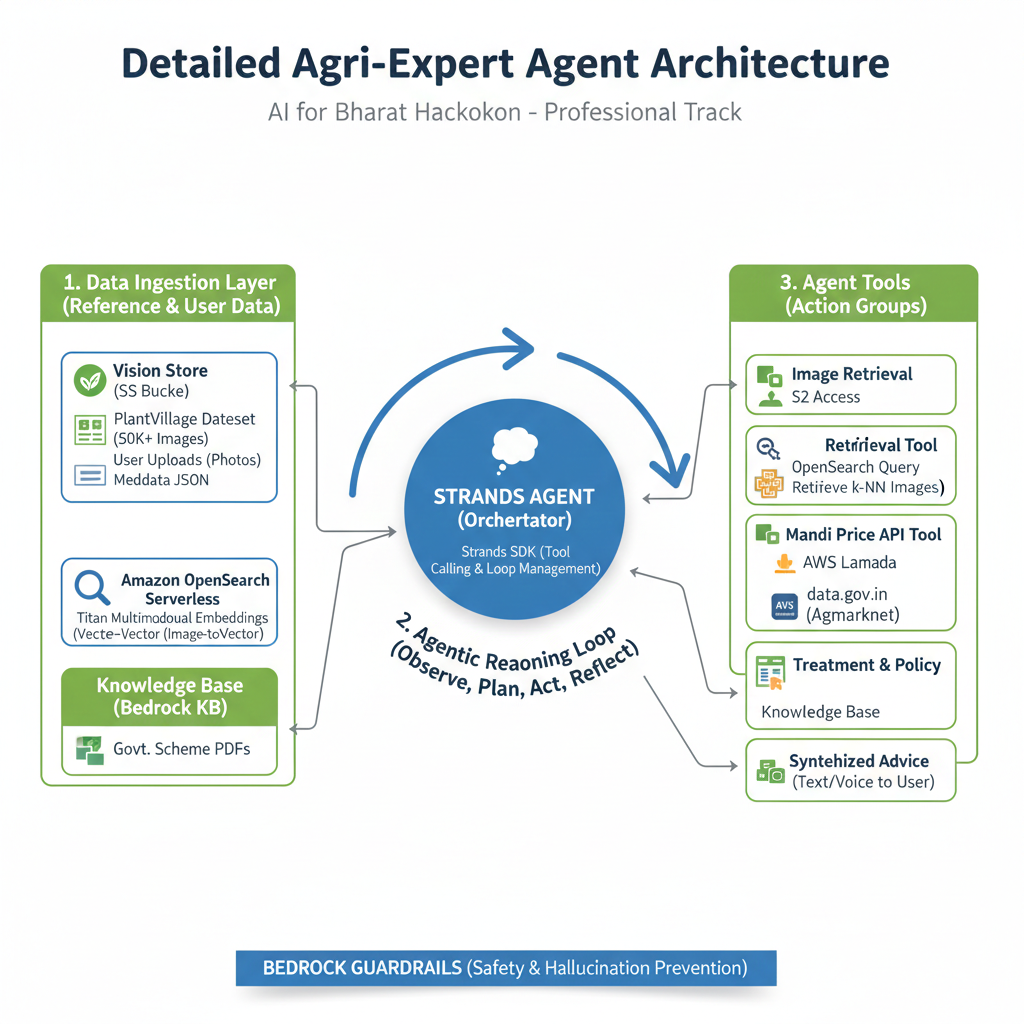

To implement the **Policy-Navigator Agent** for the professional track, you need an architecture that balances **retrieval accuracy** (to avoid legal hallucinations) with **contextual reasoning** (to explain complex schemes simply).

The "Strands" and "Bedrock" approach allows you to build this as an **Agentic RAG** system. Unlike standard RAG, an Agentic system can "reason" if it needs more info or if it should cross-reference a user's village amenities before suggesting a scheme.

### Policy-Navigator: Detailed Technical Architecture

#### 1. Knowledge Layer (The Ground Truth)

* **Source Data:** PDF/CSV files from `data.gov.in` (e.g., PKVY guidelines) are stored in an **Amazon S3** bucket.
* **Bedrock Knowledge Base:** This acts as your "Vector Engine." It automatically chunks the documents and converts them into embeddings (using *Amazon Titan Text Embeddings*).
* **Structured Data (Village Amenities):** Store the Census 2011 data in **Amazon DynamoDB** or as a separate Knowledge Base. This allows the agent to check, for example, "Does this village actually have the irrigation type required for this subsidy?"

#### 2. The Agentic Brain (Strands SDK)

The agent is defined using the **Strands SDK**, running on **Claude 3.5 Sonnet**.

* **System Prompt:** Instructs the agent to always cite its sources (using citations from the Knowledge Base) and to simplify legal language into "Farmer-first" advice.
* **Tool Calling:** The agent has access to a `SearchSchemes` tool (linked to Bedrock KB) and a `CheckVillageEligibility` tool (linked to DynamoDB/Census data).

#### 3. The Execution Flow

1. **User Input:** A user asks in a local language, "Can I get money for organic farming in my village?"
2. **Intent Classification:** The Strands Agent identifies this as a "Policy Inquiry."
3. **Reasoning Loop:**
* **Action 1:** Search the **Bedrock Knowledge Base** for "organic farming subsidies" (identifies PKVY).
* **Action 2:** Query **DynamoDB** using the user's village code to check for "existing irrigation infrastructure."


4. **Synthesis:** The agent combines the findings: "Yes, under PKVY you are eligible for ₹50,000. Your village has 'Canal Irrigation' which qualifies for the special organic cluster bonus."
5. **Safety:** **Bedrock Guardrails** filter the response to ensure no sensitive personal data is leaked and the advice is not "financial coaching" but "policy information."

---

### Implementation Tips for the Hackathon

* **Citations:** Use the `citations` field in the Bedrock Knowledge Base response to show exactly which PDF page the advice came from. This builds immense trust with judges.
* **Multilingual Support:** Use the **Amazon Translate** tool or Bedrock's native ability to translate the retrieved policy text into the user's local dialect (e.g., Bundelkhandi or Marathi).

[Build AI Agents with AWS Bedrock and Strands SDK](https://www.youtube.com/watch?v=C3tpzAwgvBA)

This video walk-through shows you how to use the Strands SDK with Claude 3.5 Sonnet in Bedrock to research knowledge bases, which is the exact core logic you need for your Policy-Navigator agent.

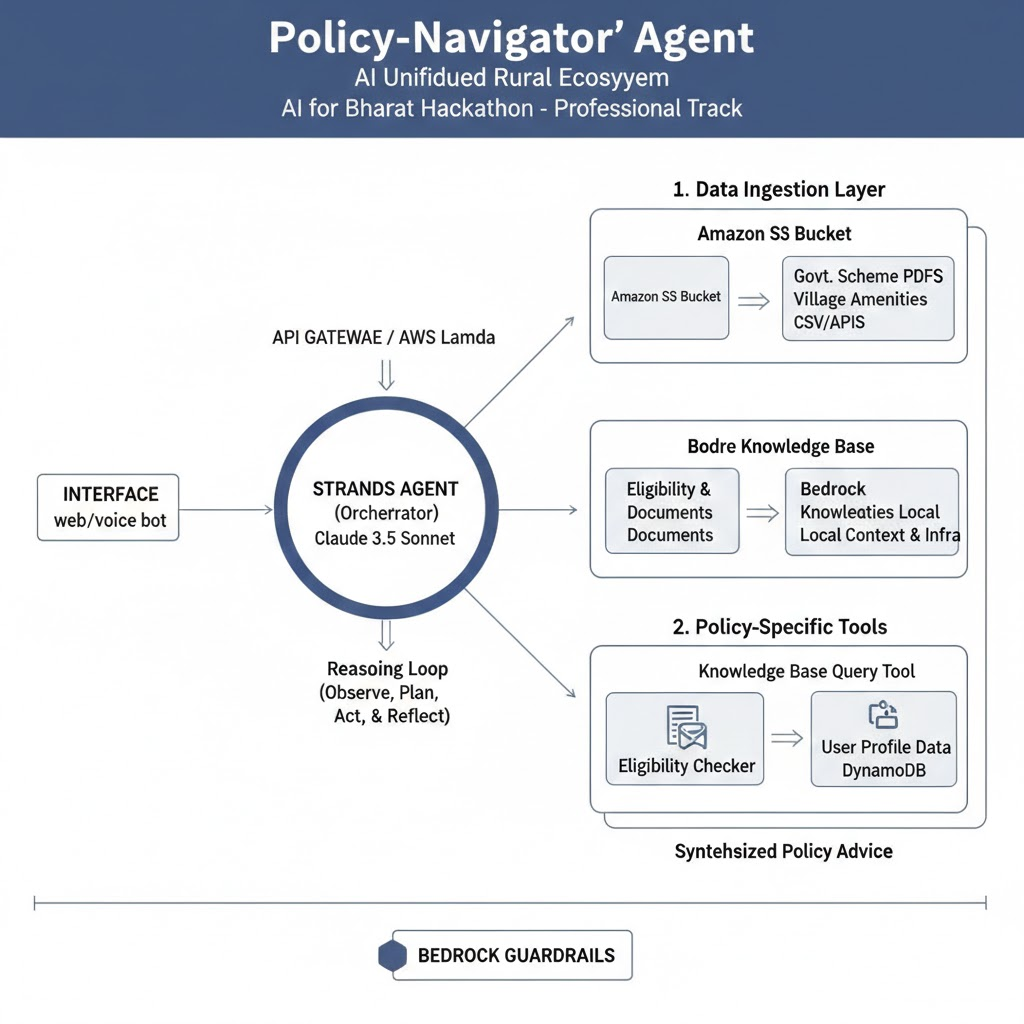

To build a professional-grade **Eco-Resource Agent** for the AI for Bharat hackathon, your architecture must focus on **Resource Intelligence**. This agent is designed to manage "Invisible Resources" like soil moisture, groundwater, and energy consumption to prevent waste.

The architecture follows a **Predict-then-Act** pattern, where the AI doesn't just describe the current state but predicts a more efficient future state.

### Eco-Resource Agent: Detailed Technical Architecture

#### 1. The Data Ingestion Layer (S3 & JSON Logs)

* **Sensor/Log Storage:** Remote sensors (or manual logs) upload JSON files to **Amazon S3**. These files contain fields like `soil_moisture`, `ambient_temp`, and `grid_power_status`.
* **Weather Grounding:** Use a **Lambda Function** to fetch regional weather forecasts (e.g., from IMD or open weather APIs). This data is also stored in S3 as context for the agent.

#### 2. The Logic Layer (Strands Code Interpreter)

* **Agent Initialization:** The agent is built using the **Strands SDK** and powered by **Claude 3.5 Sonnet** (via Bedrock).
* **Code Interpreter Tool:** This is the "Secret Sauce." Instead of just "guessing," the agent uses a **Python Code Interpreter** tool to run mathematical models on the JSON data.
* *Example:* It calculates the **Evapotranspiration rate** () to determine exactly how many liters of water a specific plot needs.



#### 3. The Multi-Agent Collaboration

The Eco-Resource Agent doesn't work in isolation. It coordinates with others via the **Strands Supervisor**:

* **Sustainability Check:** If the **Eco-Agent** finds that irrigation is needed, it checks with the **Policy-Agent** to see if there are any peak-hour electricity restrictions or subsidies for solar pump usage before giving the final "Go" to the farmer.

---

### Implementation Workflow

| Component | Technical Detail |
| --- | --- |
| **Brain** | **Claude 3.5 Sonnet** (Excels at logical reasoning and code generation). |
| **Analysis Tool** | A Strands `@tool` that parses S3 JSON logs and returns a summary of resource trends. |
| **Predictive Engine** | The agent chains a "Weather Fetcher" tool with a "Soil Model" tool to predict water needs for the next 48 hours. |
| **User Output** | A simple, actionable directive: *"Rain is expected in 6 hours. Hold irrigation to save 2,000 liters of water."* |

### Why this Architecture Wins the Professional Track

* **Scalability:** By using **Serverless Python tools** in Strands, you can scale to thousands of different soil types or micro-grids without changing your infrastructure.
* **Explainability:** The agent can show its "work" (e.g., *"Based on the 35°C temperature and 10% humidity, I calculated a high evaporation rate..."*), which builds user trust.
* **Sustainability Focus:** It prioritizes **Conservation** over **Consumption**, directly addressing the "Resource-efficient systems" pillar of the problem statement.

**Next Step:** Would you like the **Python Tool code** for the "Irrigation Calculator" that your agent would use to process the S3 sensor data?

---

[Building Intelligent AI agents with Amazon Bedrock and Strands (Workshop 4)](https://www.youtube.com/watch?v=veOzISdMI6Q)
This video is a direct recording of the AI for Bharat Workshop 4, covering the exact "Agentic" workflows and Strands SDK implementations you need to build the Eco-Resource Agent for your hackathon submission.

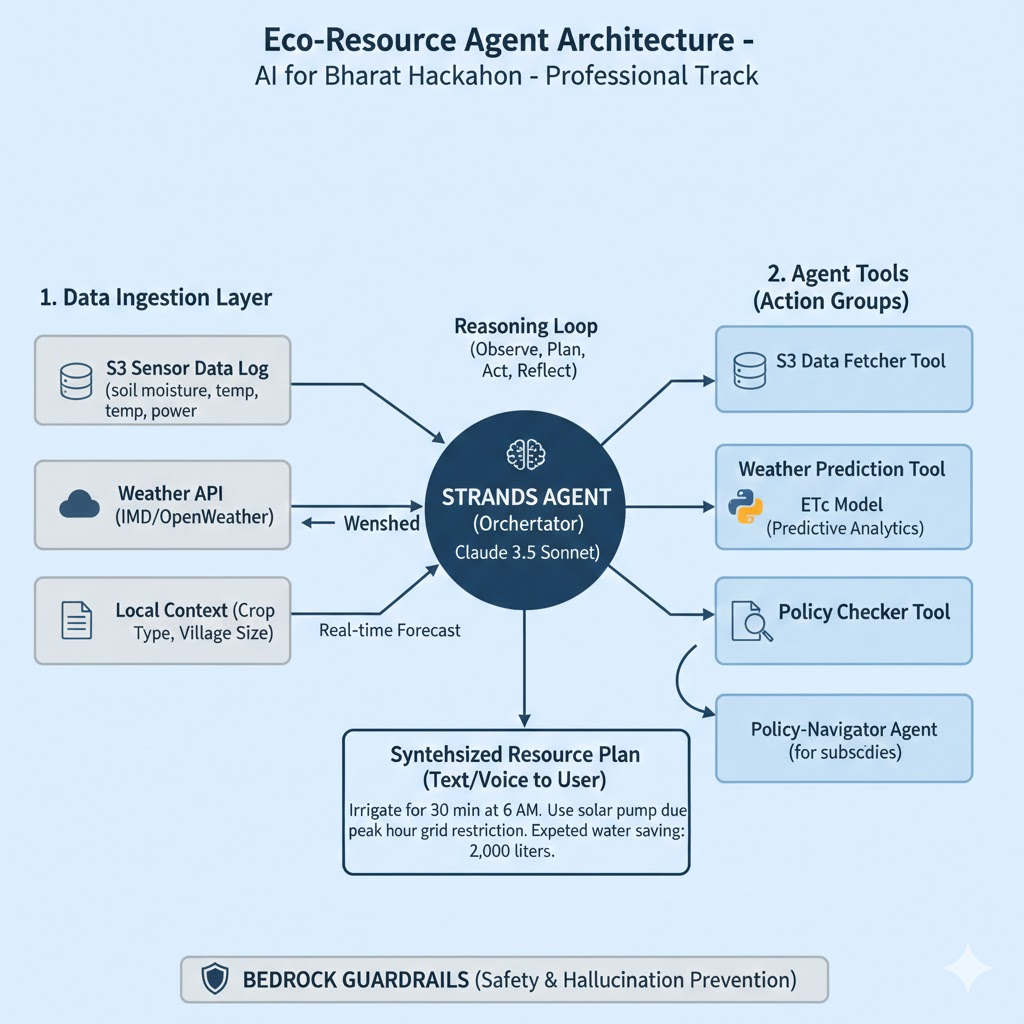

Building an **"Agri-Expert" Agent** for the professional track requires a shift from simple chatbots to an **Agentic Loop**. The architecture below details how to implement the Multimodal RAG (using PlantVillage) and Market Linkage using the **Strands SDK** and **Amazon Bedrock**.

### Detailed "Agri-Expert" Architecture

This architecture is built on a **Model-Driven approach**, where the LLM (Claude 3.5 Sonnet) uses tools to interact with your data and the physical world.

#### 1. The Ingestion Layer (Reference Data)

* **Vector Database (Amazon OpenSearch Serverless):** Stores the **PlantVillage embeddings**. You use an embedding model (like *Titan Multimodal*) to convert the 50,000 images into vectors.
* **Knowledge Base (Bedrock KB):** Stores CSV/PDF metadata about Indian crop diseases, treatment costs, and organic pesticide recipes.

#### 2. The Agentic Loop (Strands SDK)

The "Agri-Expert" is initialized as a Strands Agent. It doesn't follow a hardcoded script; it follows a **Reasoning Loop**:

1. **Observe:** User uploads a leaf photo to **S3**.
2. **Plan:** Agent decides: *"I need to search the PlantVillage vector index to see if this is a known disease."*
3. **Act:** Agent calls the `image_retrieval_tool`.
4. **Reflect:** Agent compares the query image with retrieved references. If it finds a match (e.g., "Tomato Early Blight"), it then calls the `mandi_price_tool` to check if that crop is currently valuable enough to justify expensive treatment.

#### 3. Component Breakdown

| Component | Technology | Purpose |
| --- | --- | --- |
| **Brain** | **Claude 3.5 Sonnet** | High-fidelity multimodal reasoning for disease identification. |
| **Orchestrator** | **Strands SDK** | Manages the loop and tool calls (Action Groups). |
| **Vision Store** | **Amazon S3** | Temporarily hosts user-uploaded images and the reference dataset. |
| **Retrieval** | **OpenSearch / FAISS** | Performs k-Nearest Neighbor (k-NN) search to find matching leaf patterns. |
| **External API** | **AWS Lambda** | A tool that fetches real-time prices from `data.gov.in` (Agmarknet). |

---

### Implementation Workflow for Your Hackathon

To implement this, you should set up your Python environment with the following logic:

1. **Define the Tools:** Wrap your API calls and database queries in the `@tool` decorator provided by Strands.
2. **Configure the Agent:** Pass the **Bedrock model ID** and the list of tools to the Strands `Agent` class.
3. **Ground the Prompt:** Use the "System Prompt" to give the agent its persona (Senior Agronomist) and specific instructions on how to prioritize organic treatments.

#### Why this Architecture Wins:

* **Self-Correction:** If the agent's first search in PlantVillage is inconclusive, the "Model-Driven" loop allows it to ask the user a follow-up question (e.g., *"Does the underside of the leaf have white fuzzy growth?"*) to refine its diagnosis.
* **Serverless Scaling:** Using **Bedrock AgentCore Runtime**, your agent runs in isolated micro-VMs that scale automatically, satisfying the "Professional Track" requirement for production-grade reliability.

**Next Step:** Would you like the **Python code structure** specifically for the "Image Retrieval Tool" that connects S3 to your Bedrock model?

Yes, memory is a core feature of the architecture. Because you are using the **Strands Agents SDK** and **Amazon Bedrock**, the system handles memory at two distinct levels: **Short-Term (Conversation)** and **Long-Term (Persistent)**.

### 1. Short-Term (Session) Memory

The **Supervisor Agent** maintains a "sliding window" of the current conversation. This means if a farmer mentions they have 5 acres of land in the first message, the Supervisor remembers this context when it later calls the **Eco-Resource Agent** or **Policy Agent**.

* **How it works:** Strands Agents use a `ConversationManager` that automatically keeps the most recent  messages.
* **Workshop Tool:** For a hackathon, you can use the built-in `FileSessionManager` for local testing or **S3SessionManager** for cloud deployment.

### 2. Long-Term (Persistent) Memory

To make your solution "Professional Track" ready, you can implement **Hybrid Memory**. This allows the agent to "remember" a user's specific details across days or months (e.g., past crop diseases or previous subsidy applications).

* **Episodic Memory:** Stores a summary of past sessions so the agent can say, "Welcome back! How is the rice crop we discussed last week?"
* **Semantic Memory:** Uses a Vector Store (like Amazon OpenSearch or Chroma) to search through years of history for specific facts.

### 3. Cross-Agent Memory Flow

One of the biggest advantages of your **Supervisor-Worker** setup is that the Supervisor acts as the "Central Memory Hub."

| Step | Interaction | Memory Action |
| --- | --- | --- |
| **1** | User: "My wheat has yellow spots." | **Supervisor** stores "Crop: Wheat" & "Issue: Yellow Spots" in session state. |
| **2** | **Agri-Expert** identifies "Yellow Rust." | **Supervisor** updates state with "Diagnosis: Yellow Rust." |
| **3** | User: "Is there any govt help for this?" | **Supervisor** passes "Yellow Rust" + "Wheat" context to **Policy-Agent** automatically. |

### How to Implement This in Your Code

When initializing your agent with the **Strands SDK**, you can simply attach a session manager:

```python
from strands.session.s3_session_manager import S3SessionManager
from strands import Agent

# This ensures the agent 'remembers' user-123 even after a restart
session_manager = S3SessionManager(
    session_id="user-123", 
    bucket="my-hackathon-memory-bucket"
)

agent = Agent(session_manager=session_manager)

```

**Next Step:** Since memory often requires storing user data, would you like me to show you how to set up the **AWS IAM permissions** to allow your agent to read/write to the S3 memory bucket securely?

In the professional track of **AI for Bharat**, "Responsible AI" isn't just a buzzword; it’s a technical requirement. For a solution serving rural ecosystems, this means ensuring **fairness**, **transparency**, and **safety** across your multi-agent system.

By integrating **Amazon Bedrock Guardrails** and **Responsible AI sutras**, you protect the end-user (the farmer/rural citizen) from misinformation and data misuse.

### 1. The Responsible AI Architecture (Safety Layer)

Your architecture needs a dedicated **Governance Layer** that sits between the Supervisor and the User. This ensures every input and output is filtered against specific ethical policies.

* **Input Filtering:** Detects "Prompt Injection" (users trying to bypass the AI's rules) or requests for restricted topics (like illegal chemical recipes).
* **Output Grounding:** Bedrock Guardrails check if the agent's response is actually found in your **Knowledge Base**. If the agent tries to "hallucinate" a fake government scheme, the guardrail blocks it.
* **PII Redaction:** Automatically detects and masks sensitive data like Aadhaar numbers or bank details in the conversation history to protect user privacy.

---

### 2. Implementing the "Seven Sutras" of India AI

To align with the **India AI Governance Guidelines**, your agents should adhere to these principles:

| Sutra | Technical Implementation in your Project |
| --- | --- |
| **Trust & Safety** | Use **Bedrock Guardrails** to deny "Medical" or "Financial" advice, routing users to professionals instead. |
| **People First** | Design for **Digital Literacy**. If the AI's explanation is too complex (high reading level), the **Strands Supervisor** should trigger a "Simplification Loop." |
| **Fairness & Equity** | Ensure your **Agri-Expert** isn't biased toward expensive industrial fertilizers. Ground it in "Low-Input" or "Organic" datasets (like PKVY). |
| **Accountability** | Maintain **Observability logs** (using AWS CloudWatch). Every decision the agent makes (e.g., "Why did it suggest this pesticide?") must be traceable. |

---

### 3. Practical "Guardrail" Rules for your Agents

You can configure these specific "Denied Topics" in your **Amazon Bedrock console**:

1. **Chemical Hazards:** Block advice on creating unregulated or dangerous homemade pesticides.
2. **Financial Coaching:** Ensure the **Policy-Agent** explains *eligibility* for schemes but does not give *investment* advice.
3. **Hate Speech & Polarization:** Filter responses in regional languages to ensure cultural sensitivity and communal harmony.

### 4. Transparency via "Explainability"

In your submission, show that your agent can explain *why* it gave a certain answer.

* **Example:** "I am suggesting you wait to irrigate because my **Eco-Agent** analyzed the JSON logs from S3 and found 60% soil moisture, and the weather API predicts rain at 4:00 PM today."

**Next Step:** Would you like me to help you draft the **"Ethical Considerations"** section of your hackathon blueprint, specifically highlighting how you handle data privacy for rural users?

---

[Mastering Responsible AI with Amazon Bedrock Guardrails](https://www.youtube.com/watch?v=hM2_2OF8jWw)

This video is the full recording of Workshop 4, where the AWS team demonstrates exactly how to implement the safety and guardrail logic into the Strands Agent framework to ensure your solution is responsible and production-ready.

🌱 Responsible AI Parameters for Agriculture Applications
Fairness
Ensure recommendations (fertilizer use, irrigation schedules, crop selection) are unbiased across farm sizes, regions, and socio-economic groups.

Avoid favoring large-scale farms over smallholders.

Example: AI should not recommend expensive inputs only accessible to wealthy farmers.

Reliability & Safety
Models must handle uncertainty in weather, soil, and market data.

Fail-safe design: if confidence is low, flag for human agronomist review.

Example: Avoid overconfident pesticide recommendations that could harm crops or ecosystems.

Privacy & Security
Protect farmer identity, land ownership records, and yield data.

Use secure data-sharing protocols (e.g., federated learning for soil data).

Example: Farmer-specific yield predictions should not be exposed to competitors or buyers without consent.

Inclusiveness
Design for farmers with varying literacy and digital access.

Support local languages (Marathi, Hindi, Kannada, etc. in Bharat context).

Provide voice-based interfaces for low-literacy users.

Transparency
Explain why a recommendation was made (e.g., “Based on rainfall forecast and soil nitrogen levels, apply 20kg urea”).

Show data sources (satellite, IoT sensors, government guidelines).

Example: Farmers should see the reasoning behind crop rotation advice.

Accountability
Keep audit trails of recommendations and farmer decisions.

Responsibility remains with the farmer/agronomist — AI is a copilot, not a decision-maker.

Example: If AI suggests irrigation and farmer disagrees, the override is logged.

Sustainability
Encourage eco-friendly practices (reduced chemical use, water conservation, biodiversity).

Align with UN SDGs and local agricultural policies.

Example: AI should prioritize organic pest control methods when feasible.

---

### Final Roadmap: From Prototype to Rural Impact

A professional roadmap should follow the **"Pilot-Scale-Integrate"** framework, aligning with the national vision for **Viksit Bharat 2047**.

| Phase | Timeline | Key Milestone | Technical Focus |
| --- | --- | --- | --- |
| **Phase 1: MVP & Pilot** | Q1 - Q2 2026 | Deployment in 5 "Adopter" villages. | Fine-tuning **Strands Agent** logic and grounding **Bedrock RAG** with local soil and scheme data. |
| **Phase 2: Regional Scaling** | Q3 - Q4 2026 | Partnering with 10+ FPOs (Farmer Producer Orgs). | Integrating real-time IoT sensors into the **Resource-Agent** (S3 data ingestion). |
| **Phase 3: Platform Maturity** | 2027 | Integration with **IndiaAI Compute Pillar**. | Migrating to **Sovereign LLMs** (like BharatGen) to ensure data privacy and cultural nuance. |
| **Phase 4: Nationwide Rollout** | 2028+ | Integration with **Digital ShramSetu**. | Opening APIs for private agritech companies to plug into your Multi-Agent "Operating System." |

---

### Conclusion: The "Gram-Setu" Vision

Your final slide or paragraph should synthesize the technical complexity with human value:

> "The **Gram-Setu** platform represents a shift from reactive tools to **Proactive Rural Intelligence**. By orchestrating specialized agents through **Amazon Bedrock** and **Strands**, we don't just answer questions—we anticipate needs. We link a crop disease to a financial subsidy and a water-saving irrigation plan in one seamless, local-language conversation. Our solution is built for the professional track: it is **serverless, scalable, and sovereign**, ensuring that the heart of Bharat isn't just part of the digital revolution, but leading it."

### Submission Checklist for You

Before you hit "Submit," ensure your documentation covers:

1. **Technical Stack:** Mention Strands SDK, Bedrock (Claude 3.5), S3, and Lambda.
2. **Multimodality:** Explicitly show how images of leaves/crops are processed.
3. **Local Language:** Highlight that the system works via voice/text in regional languages.
4. **Security:** State that you use **Bedrock Guardrails** to ensure safe, non-hallucinated advice.

**Would you like me to generate a 3-minute video pitch script for your final submission?**

---

[AI For Bharat Program 2025 Overview](https://www.youtube.com/watch?v=veOzISdMI6Q)

This video provides essential context on the AI for Bharat program goals and submission criteria, helping you align your final pitch and roadmap with the specific expectations of the organizers.